## This is a script just to test making an ensemble model from a bunch of output code from the base models

In [1]:
import sklearn
import pandas as pd
import numpy
import pickle
import matplotlib.pyplot as plt
print(sklearn.__version__)

1.7.1


In [2]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn import svm
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.metrics import DetCurveDisplay

# Step 1: Import Base Model Outputs & Clean Up

In [3]:
dipoff_df = pd.read_csv("~/zebrafish_output/CRISPR_DIPOFF_output_thresh.csv") #Note - dipoff predict cleavage based on threshold of 1E-24 - manual step
net_df = pd.read_csv("~/zebrafish_output/CRISPR_net_output.csv")
pi_df = pd.read_csv("~/zebrafish_output/picrispr_output.csv")
mastermerged_df = pd.read_csv("~/zebrafish_output/master_merged.csv")

In [4]:
dipoff_df[:6]

,sgRNA,targetDNA,predictions,probabilities
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,1
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,1
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,0


In [5]:
dipoff_df = dipoff_df[dipoff_df.duplicated(subset=['sgRNA', 'targetDNA'], keep='first') == False]
len(dipoff_df)

3132

In [6]:
net_df[["CRISPR_Net_score"]] = 1 - net_df[["CRISPR_Net_score"]]
net_df[:6]

,on_seq,off_seq,CRISPR_Net_score
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0.996028
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,1.000000
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0.984259
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0.789198
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0.811715
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0.999663


In [7]:
net_df = net_df[net_df.duplicated(subset=['on_seq', 'off_seq'], keep='first') == False]
len(net_df)

3132

In [8]:
pi_df[:6]

,target_sequence,grna_target_sequence,piCRISPR prediction
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,5.912094
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,4.778482
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,5.635037
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,6.433622
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,5.368467
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,4.998325


In [9]:
pi_df = pi_df[pi_df.duplicated(subset=['target_sequence','grna_target_sequence'], keep='first') == False]
len(pi_df)

3132

In [10]:
mastermerged_df[:6]

,Accession,Name,WindowSequence,OffTargetSequence,Cell,Targetsite,TargetSequence,Position.Pvalue,Narrow.Pvalue,Position.Control.Pvalue,Narrow.Control.Pvalue,Cleavage,gene,sgRNA_withPAM,cfd_score
0,ERR5961117,10:19095356-19095379,TTTCTCTCTGCCTAGTAGCTCTTATCCAATCACA,TGATTGGATAAGAGCTACTAGGC,si:dkey-191g9.7_grna2,ERR5961117,GGAATGGATGAGAGCTACAAGGG,0.000000,0.000000,0.004312,0.004326,True,NaN,NaN,NaN
1,ERR5961135,5:46534805-46534828,atcttgccgccatcaccgtgctccactagggt,CTAGTGGAGCACGGTGATGGCGG,pdzk1_grna1,ERR5961135,CGCGTGGAGCACGGCGAGGAGGG,0.000000,0.000000,0.008081,0.008115,True,NaN,NaN,NaN
2,ERR5961098,12:37496976-37496999,CCATATCGTGAGATGAATGGCTCACCAGGAGGCCCAGGGGCTCCTA...,TTAGGAGCCCCTGGGCCTCCTGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.000013,0.000041,0.169973,0.170428,True,NaN,NaN,NaN
3,ERR5961098,12:35110599-35110622,gtcattccagaaatccaaagtctcccagaagttccaggagtctccc...,CGGGAGACTCCTGGAACTTCTGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.002998,0.006385,0.169973,0.170428,True,NaN,NaN,NaN
4,ERR5961098,12:15160501-15160524,ATAAAGGcagacatcccaagtctcccggaagttccaggagtctccc...,CGGGAGACTCCTGGAACTTCCGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.002998,0.006385,0.169973,0.170428,True,NaN,NaN,NaN
5,ERR5961098,11:30034636-30034659,gttaacccaacgctcaactcccaacctggaggtccaggacatacac...,TGTGTATGTCCTGGACCTCCAGG,arhgap11a_grna2,ERR5961098,TGGGAAGCTCCTGGGCCTTCAGG,0.001880,0.004263,0.169973,0.170428,True,NaN,NaN,NaN


In [11]:
len(mastermerged_df)

3353

# Step 2: Combine Dataframes & Transform As Needed

In [12]:
combined_df = dipoff_df
combined_df = combined_df.rename(columns = {'predictions': 'dipoff_predictions', 'probabilities': 'dipoff_probabilities'})
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,1
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,1
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,0


In [13]:
len(combined_df)

3132

In [14]:
combined_df = combined_df.merge(net_df, how='inner', left_on=['sgRNA', 'targetDNA'], right_on=['on_seq', 'off_seq'])
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,on_seq,off_seq,CRISPR_Net_score
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,1,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0.996028
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,1.000000
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,1,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0.984259
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0.789198
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0.811715
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,0,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0.999663


In [15]:
len(combined_df)

3132

In [16]:
combined_df = combined_df.drop('on_seq', axis=1)
combined_df = combined_df.drop('off_seq', axis=1)
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,1,0.996028
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1,1.000000
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,1,0.984259
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1,0.789198
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1,0.811715
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,0,0.999663


In [17]:
combined_df = combined_df.merge(pi_df, how='inner', left_on=['sgRNA', 'targetDNA'], right_on=['grna_target_sequence', 'target_sequence'])
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,target_sequence,grna_target_sequence,piCRISPR prediction
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,1,0.996028,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,5.912094
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1,1.000000,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,4.778482
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,1,0.984259,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,5.635037
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1,0.789198,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,6.433622
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1,0.811715,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,5.368467
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,0,0.999663,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,4.998325


In [18]:
len(combined_df)

3132

In [19]:
combined_df = combined_df.drop('target_sequence', axis=1)
combined_df = combined_df.drop('grna_target_sequence', axis=1)
combined_df[:6]

,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,1,0.996028,5.912094
1,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1,1.000000,4.778482
2,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,1,0.984259,5.635037
3,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1,0.789198,6.433622
4,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1,0.811715,5.368467
5,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,0,0.999663,4.998325


In [20]:
mastermerged_df = mastermerged_df[['OffTargetSequence', 'TargetSequence', 'Cleavage']]
mastermerged_df[:6]

,OffTargetSequence,TargetSequence,Cleavage
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,True
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,True
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,True
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,True


In [21]:
combined_df = mastermerged_df.merge(combined_df, how='inner', left_on=['OffTargetSequence', 'TargetSequence'], right_on=['targetDNA', 'sgRNA'])
combined_df[:6]

,OffTargetSequence,TargetSequence,Cleavage,sgRNA,targetDNA,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,True,GGAATGGATGAGAGCTACAAGGG,TGATTGGATAAGAGCTACTAGGC,0,1,0.996028,5.912094
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,True,CGCGTGGAGCACGGCGAGGAGGG,CTAGTGGAGCACGGTGATGGCGG,0,1,1.000000,4.778482
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,TTAGGAGCCCCTGGGCCTCCTGG,0,1,0.984259,5.635037
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCTGG,0,1,0.789198,6.433622
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,CGGGAGACTCCTGGAACTTCCGG,0,1,0.811715,5.368467
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,True,TGGGAAGCTCCTGGGCCTTCAGG,TGTGTATGTCCTGGACCTCCAGG,0,0,0.999663,4.998325


In [22]:
len(combined_df)

3353

## We lost a few rows there, presumably because they weren't in the master merged csv for some reason

In [23]:
combined_df = combined_df.drop('sgRNA', axis=1)
combined_df = combined_df.drop('targetDNA', axis=1)

In [24]:
combined_df[:20]

,OffTargetSequence,TargetSequence,Cleavage,dipoff_predictions,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,TGATTGGATAAGAGCTACTAGGC,GGAATGGATGAGAGCTACAAGGG,True,0,1,0.996028,5.912094
1,CTAGTGGAGCACGGTGATGGCGG,CGCGTGGAGCACGGCGAGGAGGG,True,0,1,1.000000,4.778482
2,TTAGGAGCCCCTGGGCCTCCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1,0.984259,5.635037
3,CGGGAGACTCCTGGAACTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1,0.789198,6.433622
4,CGGGAGACTCCTGGAACTTCCGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1,0.811715,5.368467
5,TGTGTATGTCCTGGACCTCCAGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,0,0.999663,4.998325
6,AGAAAGGCTCCTGGTCCTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1,0.993437,5.949183
7,ATGCCAACTCCTGGGCCTTCAGA,TGGGAAGCTCCTGGGCCTTCAGG,True,0,0,0.997777,4.991781
8,AGGGAGACTCCCGGACCTTCTGG,TGGGAAGCTCCTGGGCCTTCAGG,True,0,1,0.803260,5.099304
9,CTTGTGGAGCAGGGCATGGATGG,CGCGTGGAGCACGGCGAGGAGGG,True,0,1,1.000000,3.897562


In [25]:
combined_df.to_csv('combined_df.csv')

# Step 3: Train Logistic Regression & Voting Models

In [26]:
combined_df[["Cleavage"]][:6]

,Cleavage
0,True
1,True
2,True
3,True
4,True
5,True


In [27]:
# just need the probabilities now that they're in order

training_unboosted_df = combined_df[["dipoff_probabilities", "CRISPR_Net_score", "piCRISPR prediction"]]
training_unboosted_df[:6]

,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,1,0.996028,5.912094
1,1,1.000000,4.778482
2,1,0.984259,5.635037
3,1,0.789198,6.433622
4,1,0.811715,5.368467
5,0,0.999663,4.998325


In [28]:
# training regression models for each base model to boost them/set thresholds, then replacing the results

test_model_dipoff = LogisticRegressionCV().fit(training_unboosted_df[["dipoff_probabilities"]], 
                                               combined_df[["Cleavage"]].values.ravel())

test_model_pi = LogisticRegressionCV().fit(training_unboosted_df[["piCRISPR prediction"]], 
                                           combined_df[["Cleavage"]].values.ravel())

test_model_net = LogisticRegressionCV().fit(training_unboosted_df[["CRISPR_Net_score"]], 
                                            combined_df[["Cleavage"]].values.ravel())

In [29]:
# making sure it worked

yhat = test_model_dipoff.predict_proba(training_unboosted_df[["dipoff_probabilities"]][:6])
print(yhat)
test_model_dipoff.classes_

[[0.09786362 0.90213638]
 [0.09786362 0.90213638]
 [0.09786362 0.90213638]
 [0.09786362 0.90213638]
 [0.09786362 0.90213638]
 [0.5714763  0.4285237 ]]


array([False,  True])

In [30]:
# setting training df values equal to test model predictions

training_df = training_unboosted_df

dipoff_pred = test_model_dipoff.predict_proba(training_unboosted_df[["dipoff_probabilities"]])

pi_pred = test_model_pi.predict_proba(training_unboosted_df[["piCRISPR prediction"]])

net_pred = test_model_net.predict_proba(training_unboosted_df[["CRISPR_Net_score"]])

# training_df[["dipoff_probabilities"]] = pd.DataFrame(dipoff_pred[:, 1], columns = ["dipoff_probabilities"])
training_df[["piCRISPR prediction"]] = pd.DataFrame(pi_pred[:, 1], columns = ["dipoff_probabilities"])
training_df[["CRISPR_Net_score"]] = pd.DataFrame(net_pred[:, 1], columns = ["dipoff_probabilities"])
training_df[:6]

/tmp/ipykernel_2574888/1760928390.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[["piCRISPR prediction"]] = pd.DataFrame(pi_pred[:, 1], columns = ["dipoff_probabilities"])
/tmp/ipykernel_2574888/1760928390.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[["CRISPR_Net_score"]] = pd.DataFrame(net_pred[:, 1], columns = ["dipoff_probabilities"])


,dipoff_probabilities,CRISPR_Net_score,piCRISPR prediction
0,1,0.824902,0.981196
1,1,0.826080,0.951119
2,1,0.821374,0.976191
3,1,0.754734,0.987973
4,1,0.763215,0.970161
5,0,0.825980,0.959283


In [31]:
# here's where the magic happens

# column-vectors from combined_df couldn't be used as the target for training for some reason, so I had to convert it
# except numpy wouldn't convert it with ravel() alone, so I had to use .values first

test_model_log = LogisticRegressionCV().fit(training_df, combined_df[["Cleavage"]].values.ravel())

In [32]:
# just to be sure it saved it right

type(test_model_log)

sklearn.linear_model._logistic.LogisticRegressionCV

In [33]:
# testing its predictions

yhat = test_model_log.predict_proba(training_df[:20])
print(yhat)

[[0.00447386 0.99552614]
 [0.00450099 0.99549901]
 [0.00472016 0.99527984]
 [0.01195238 0.98804762]
 [0.01075453 0.98924547]
 [0.00732745 0.99267255]
 [0.0045209  0.9954791 ]
 [0.00738658 0.99261342]
 [0.01130615 0.98869385]
 [0.00467646 0.99532354]
 [0.23254639 0.76745361]
 [0.00773652 0.99226348]
 [0.00516148 0.99483852]
 [0.00476269 0.99523731]
 [0.00458137 0.99541863]
 [0.00515497 0.99484503]
 [0.00626835 0.99373165]
 [0.00491385 0.99508615]
 [0.00721827 0.99278173]
 [0.00573545 0.99426455]]


In [34]:
test_model_log.classes_

array([False,  True])

In [35]:
test_model_linear = linear_model.LinearRegression().fit(training_df, combined_df[["Cleavage"]].values.ravel())

In [36]:
type(test_model_linear)

sklearn.linear_model._base.LinearRegression

In [37]:
yhat = test_model_linear.predict(training_df[:20])
print(yhat)

[1.01862678 1.01916452 1.01175009 0.8877467  0.90262482 1.00050199
 1.01721519 0.9994443  0.89629267 1.01635518 0.4633914  0.99598513
 1.00844928 1.01483746 1.01739199 1.00907398 0.99035558 1.01265243
 0.96501873 0.99957545]


In [38]:
# pickle

with open('test_model_log.pkl','wb') as f:
    pickle.dump(test_model_log,f)
    
with open('test_model_linear.pkl','wb') as f:
    pickle.dump(test_model_linear,f)

# Step 4: Visualize Performance

In [39]:
cleavage_array = combined_df[["Cleavage"]].to_numpy()
dipoff_pred_array = training_df[["dipoff_probabilities"]].to_numpy()
net_pred_array = training_df[["CRISPR_Net_score"]].to_numpy()
pi_pred_array = training_df[["piCRISPR prediction"]].to_numpy()
yhat = test_model_log.predict_proba(training_df)
log_pred_df = pd.DataFrame(yhat, columns=['False', 'True'])
print (log_pred_df)
log_pred_array = log_pred_df[["True"]].to_numpy()
yhat = test_model_linear.predict(training_df)
linear_pred_df = pd.DataFrame(yhat)
print (linear_pred_df)
linear_pred_array = linear_pred_df.to_numpy()

         False      True
0     0.004474  0.995526
1     0.004501  0.995499
2     0.004720  0.995280
3     0.011952  0.988048
4     0.010755  0.989245
...        ...       ...
3348  0.866436  0.133564
3349  0.855404  0.144596
3350  0.834076  0.165924
3351  0.838926  0.161074
3352  0.895017  0.104983

[3353 rows x 2 columns]
             0
0     1.018627
1     1.019165
2     1.011750
3     0.887747
4     0.902625
...        ...
3348  0.130931
3349  0.137671
3350  0.149578
3351  0.146984
3352  0.110952

[3353 rows x 1 columns]


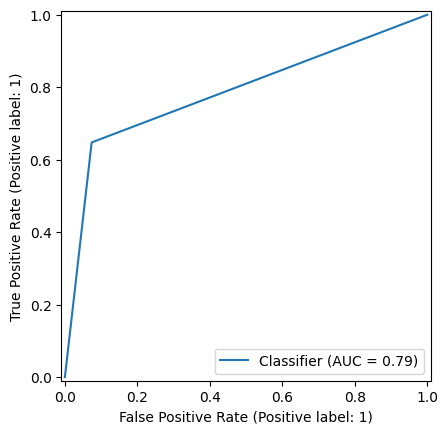

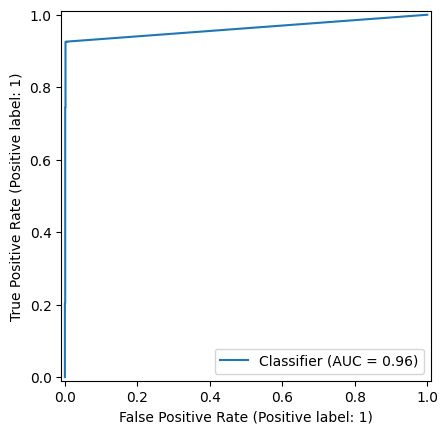

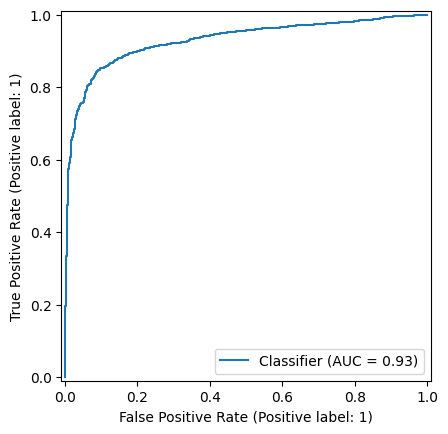

In [40]:
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array)
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array)
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array)

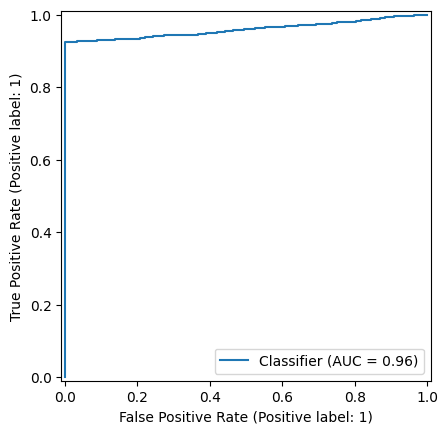

In [41]:
RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array)

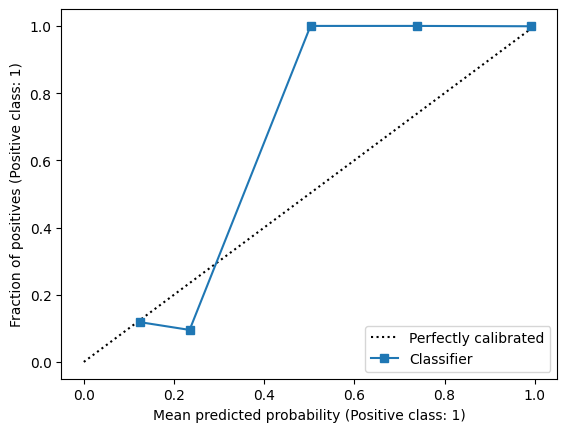

In [42]:
disp = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array)
plt.show()

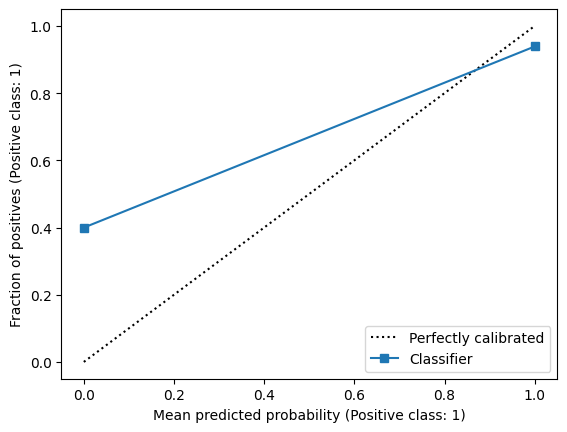

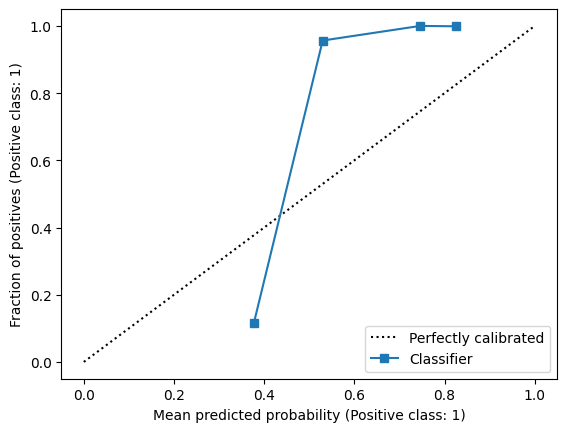

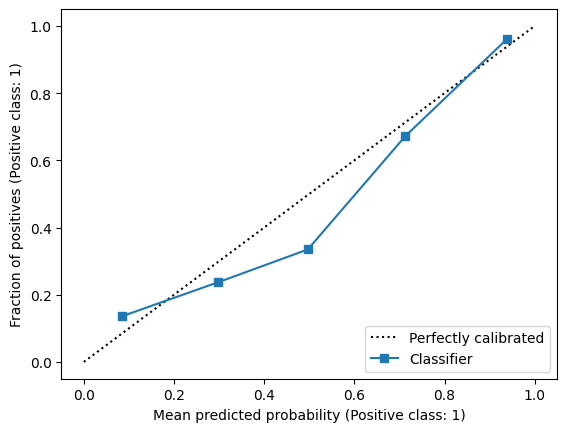

In [43]:
CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array)
CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array)
CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array)

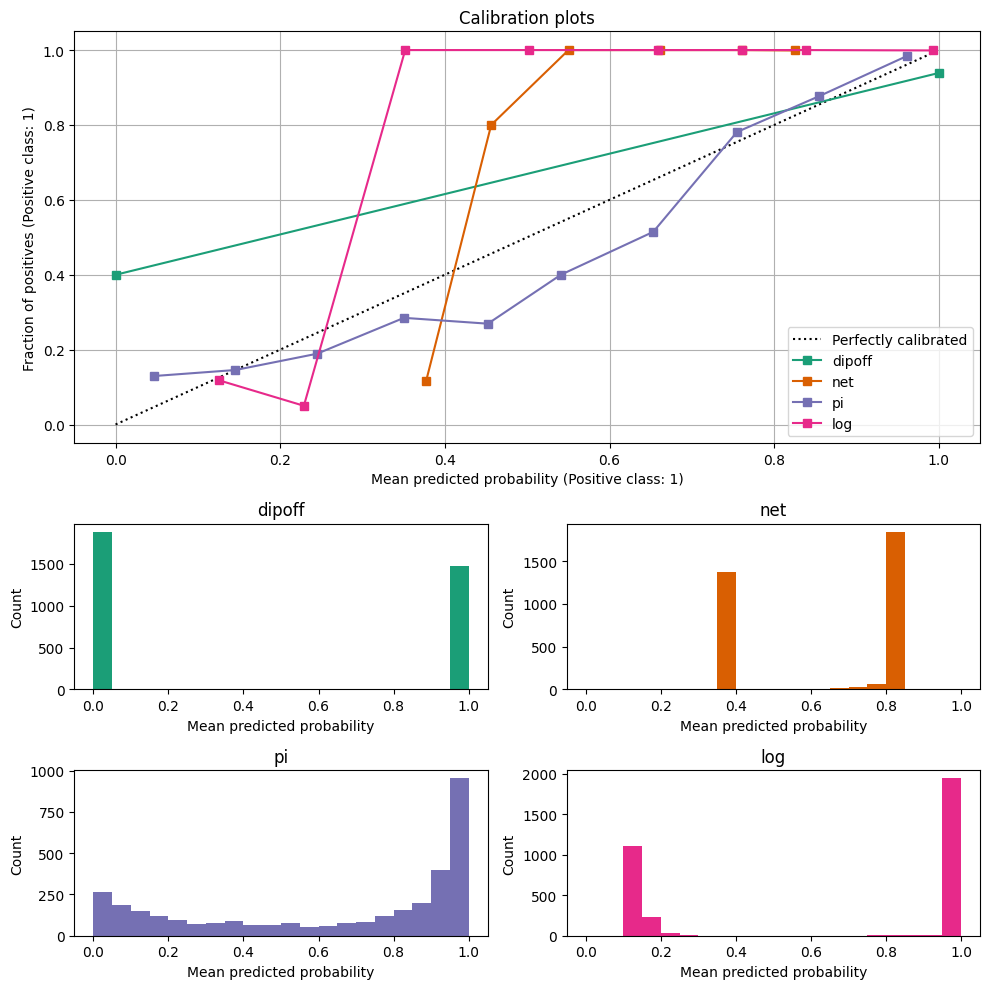

In [44]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array, n_bins=10, name="dipoff",
        ax=ax_calibration_curve, color=colors(0))
calibration_displays["dipoff"] = display
display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array, n_bins=10, name="net",
        ax=ax_calibration_curve, color=colors(1))
calibration_displays["net"] = display
display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array, n_bins=10, name="pi",
        ax=ax_calibration_curve, color=colors(2))
calibration_displays["pi"] = display
display = CalibrationDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array, n_bins=10, name="log",
        ax=ax_calibration_curve, color=colors(3))
calibration_displays["log"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
row, col = grid_positions[0]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["dipoff"].y_prob,
        range=(0, 1),
        bins=20,
        label="dipoff",
        color=colors(0),)
ax.set(title="dipoff", xlabel="Mean predicted probability", ylabel="Count")

row, col = grid_positions[1]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["net"].y_prob,
        range=(0, 1),
        bins=20,
        label="net",
        color=colors(1),)
ax.set(title="net", xlabel="Mean predicted probability", ylabel="Count")

row, col = grid_positions[2]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["pi"].y_prob,
        range=(0, 1),
        bins=20,
        label="pi",
        color=colors(2),)
ax.set(title="pi", xlabel="Mean predicted probability", ylabel="Count")

row, col = grid_positions[3]
ax = fig.add_subplot(gs[row, col])
ax.hist(
        calibration_displays["log"].y_prob,
        range=(0, 1),
        bins=20,
        label="log",
        color=colors(3),)
ax.set(title="log", xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

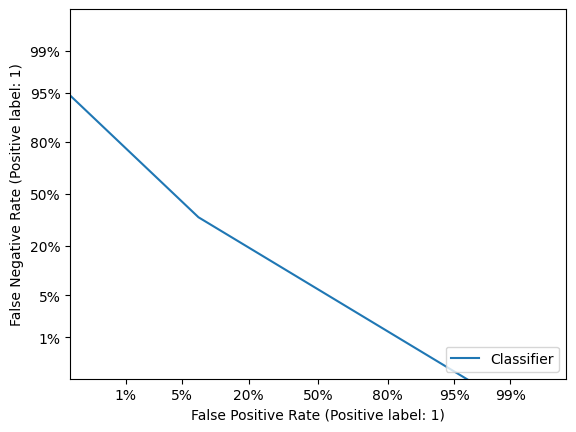

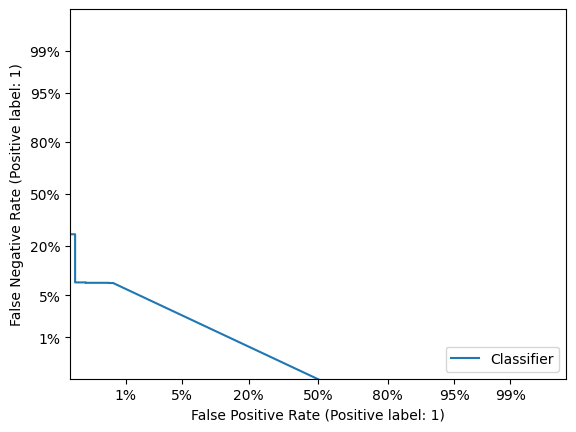

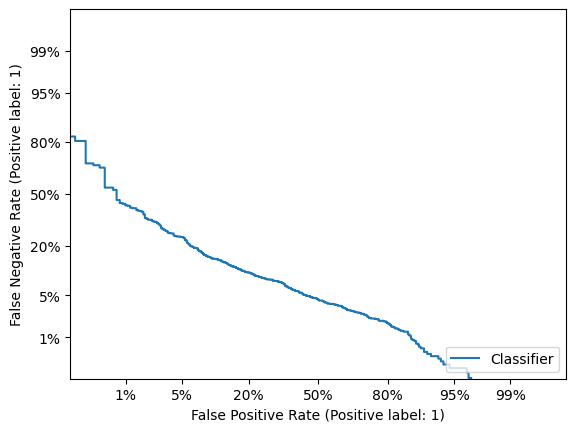

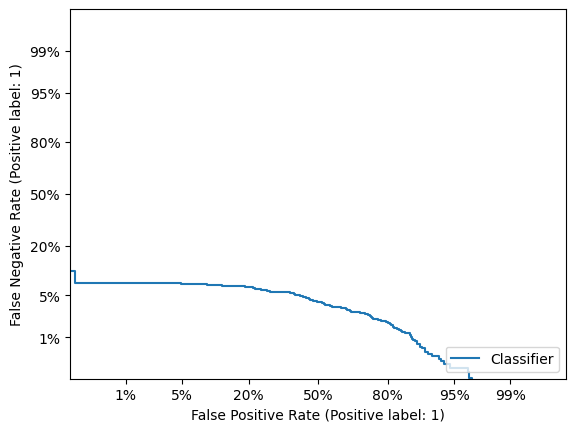

In [45]:
from sklearn.metrics import DetCurveDisplay
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array)
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array)
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array)
DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array)
plt.show()

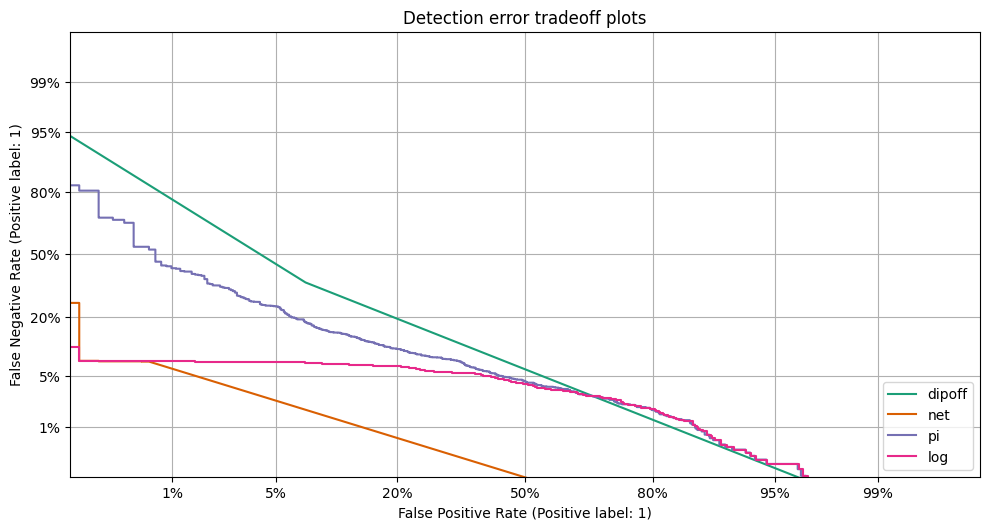

In [46]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array, name="dipoff",
        ax=ax_calibration_curve, color=colors(0))
calibration_displays["dipoff"] = display
display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array, name="net",
        ax=ax_calibration_curve, color=colors(1))
calibration_displays["net"] = display
display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array, name="pi",
        ax=ax_calibration_curve, color=colors(2))
calibration_displays["pi"] = display
display = DetCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array, name="log",
        ax=ax_calibration_curve, color=colors(3))
calibration_displays["log"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Detection error tradeoff plots")

plt.tight_layout()
plt.show()

/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/jsinohui/.local/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


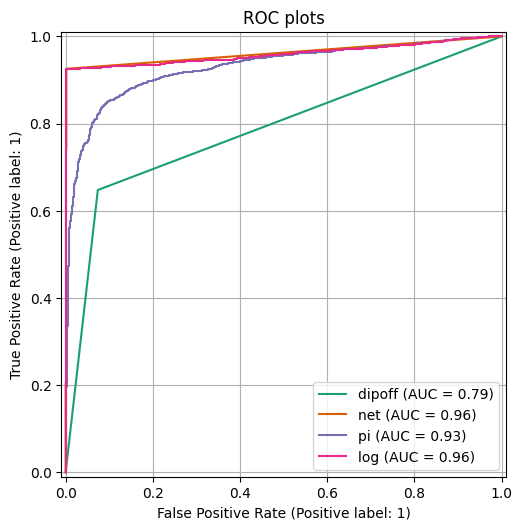

In [47]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], dipoff_pred_array, name="dipoff",
        ax=ax_calibration_curve, color=colors(0))
calibration_displays["dipoff"] = display
display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], net_pred_array, name="net",
        ax=ax_calibration_curve, color=colors(1))
calibration_displays["net"] = display
display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], pi_pred_array, name="pi",
        ax=ax_calibration_curve, color=colors(2))
calibration_displays["pi"] = display
display = RocCurveDisplay.from_predictions(combined_df[["Cleavage"]], log_pred_array, name="log",
        ax=ax_calibration_curve, color=colors(3))
calibration_displays["log"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("ROC plots")

plt.tight_layout()
plt.show()

In [48]:
from sklearn.metrics import brier_score_loss
brier_array = []
brier_array.append(brier_score_loss(combined_df[["Cleavage"]], dipoff_pred_array))
brier_array.append(brier_score_loss(combined_df[["Cleavage"]], net_pred_array))
brier_array.append(brier_score_loss(combined_df[["Cleavage"]], pi_pred_array))
brier_array.append(brier_score_loss(combined_df[["Cleavage"]], log_pred_array))
brier_array

[0.25111840143155384,
 0.09114433874038477,
 0.10148597145325461,
 0.044166578654975294]